# Parallel DBSCAN implementation
Based on Huang, Fang, Qiang Zhu, Ji Zhou, Jian Tao, Xiaocheng Zhou, Du Jin, Xicheng Tan, and Lizhe Wang. "Research on the parallelization of the DBSCAN clustering algorithm for spatial data mining based on the spark platform." Remote Sensing 9, no. 12 (2017): 1301.

## Implementation ditails
1. Performance optimizations suggested by the authors of the paper:
    1. Spark broadcast variables and accumulators in order to improve performance
    1. KyroSerizalizer for data serialization


## Difference from the 

## Definitions
* __Core points:__ a point _p_ is a _core_ point if it has neighbors within a given radius _(eps)_ and the number of neighbors is at least _minpts_.
* __Directly density-reachable:__ a point _y_ is directly _density-reachable_ from _x_ if _y_ is within _eps-neighborhood_ of _x_ and _x_ is a _core point_.
* __Density-reachable:__ a point _y_ is _density-reachable_ from x if there is a chain of points _p1, p2, ..., pn=y_ such that p1 is directly density-reachable and _p2, ..., pn_ are directly density-reachable to each previous point in the chain.

## Algorithm outline
1. Split the data to box partitions based on location in such a way that points in the same partition are close to each other
1. Expand boundies of each partition
1. Apply the traditional DBSCAN on each box and assign each point to a cluster
1. Merge clusters: If the same point has been lableled as part of a cluster in two different boxes, it means that those two clusters are actually one single cluster and they should be merged

In [81]:
from dataclasses import dataclass

from numpy import array
import numpy as np

from sklearn.cluster import DBSCAN

import matplotlib
import matplotlib.pyplot as plt

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

import operator
from pprint import pprint

In [2]:
# Enable inline plots
%matplotlib inline

if 'sc' not in locals():
    conf = SparkConf()
else:
    conf = sc.getConf()
conf.set("spark.python.profile", "true") # For debug
conf.set("spark.driver.memory", "16G")   # TODO: Should be adapted to the environment
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer") # Recommended by the authors

if 'sc' not in locals():
    sc = SparkContext(conf=conf)
    spark = SparkSession(sc)
sc.setLogLevel('ERROR')

# For reproducability of results
RANDOM_SEED = 30
sc.getConf().getAll()

[('spark.driver.memory', '16G'),
 ('spark.driver.port', '41135'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '19b8e07a1dbc'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.id', 'local-1640942575893'),
 ('spark.driver.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.app.startTime', '1640942574385'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.python.profile', 'true'),
 ('spark.executor.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.ui.showConsoleProgress', 'true')]

In [3]:
def parse_line(line):
    data_vector = tuple(map(float, line.strip().split()[:2]))
    key = hash(line)
    return key, data_vector

data = sc.textFile("../data_samples/dbscan.txt")
parsed_data = data.map(lambda line: parse_line(line))
parsed_data.cache()
parsed_data.take(5)

[(3195514837474607533, (15.55, 28.65)),
 (2828153323134883938, (14.9, 27.55)),
 (4565759698401697272, (14.45, 28.35)),
 (-7821634222920811163, (14.15, 28.8)),
 (3976224833405897861, (13.75, 28.05))]

In [4]:
clustering = DBSCAN(eps=1.2, min_samples=3).fit(parsed_data.map(operator.itemgetter(1)).collect())
labels = clustering.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [5]:
def cmap_with_noice(ncolros=7):
    """
    Create a special color map for DBSCAN alorithm.
    It uses a regualr color map but map the smallest value to black.
    We asume that the noice is labled with -1 and all the other labels are non negative
    """
    rainbow = plt.get_cmap('rainbow', ncolros)
    newcolors = rainbow(np.linspace(0, 1, ncolros))
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors, 0, black, 0)  
    return matplotlib.colors.ListedColormap(newcolors)

dbscan_cmap = cmap_with_noice()

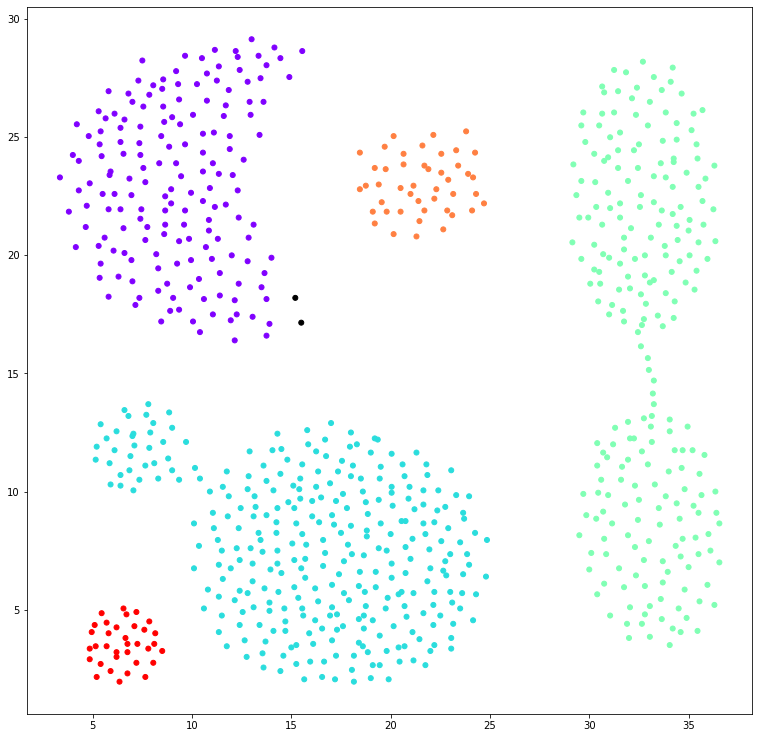

In [6]:
x, y = zip(*parsed_data.map(operator.itemgetter(1)).collect())

fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=25, c=labels, cmap=dbscan_cmap, marker="o")

In [7]:
parsed_data.map(operator.itemgetter(1)).toDF().describe().show()

+-------+-----------------+------------------+
|summary|               _1|                _2|
+-------+-----------------+------------------+
|  count|              788|               788|
|   mean|19.56681472081219|14.171763959390871|
| stddev|9.922042363186147| 8.089683474291608|
|    min|             3.35|              1.95|
|    max|            36.55|             29.15|
+-------+-----------------+------------------+



In [68]:
@dataclass
class BoundingBox:
    """
    representation of a boudnding box
    """
    lower: np.array
    upper: np.array
    
    def expand(self, expand_ratio):
        self.lower -= expand_ratio
        self.upper += expand_ratio
    
    @staticmethod
    def from_centers_and_deletas(centers, deltas):
        return BoundingBox(lower=centers - deltas / 2, upper=centers + deltas / 2)

def dataset_bounderies(data: pyspark.RDD):
    """
    :param data: RDD of sturcutre (key, k-dim vector)
    :returns: 2D array, each row contains represents a linspace vector for coresponding axis
    """
    df = parsed_data.map(operator.itemgetter(1)).toDF()
    min_values = array(df.describe().filter('summary = "min"').rdd.collect()[0][1:], float)
    max_values = array(df.describe().filter('summary = "max"').rdd.collect()[0][1:], float)
    return min_values, max_values

def generate_boudning_boxes(min_values, max_values, partitions_per_axis=3):
    """
    Splits the space to k-dim bounding boxes
    :param partitions_per_axis: number of partitions to generate on each of the axis.
        final partitions number will be partitions_per_axis ** k
    """
    deltas = (max_values - min_values) / partitions_per_axis
    axis_centers = np.linspace(
        start=min_values + deltas / 2, 
        stop=max_values - deltas / 2, 
        num=partitions_per_axis, 
        endpoint=True,
        axis=1
    )
    grid = np.meshgrid(*axis_centers)
    cells_centers = np.vstack(tuple(map(np.ravel, grid))).T.astype("float64")
    cells = list(map(lambda centers: BoundingBox.from_centers_and_deletas(centers, deltas), cells_centers))
    return cells


In [63]:
def set_partition_labels(data: pyspark.RDD, grid: np.array) -> pyspark.RDD:
    """
    :param data: each row of form ((key, k-dim vector)
    :param grid: 2D array represntation of the grid. 
        Each row is a linspace vector reprentig intervals for specific axis
    :returns: new pyspark.RDD with the same strucutre as structured_data were 
        each partition is set to be the position of ((key, partition, claster), k-dim vector)
    """
    def get_partition(point):
        return tuple(np.searchsorted(axis, coordinate, side='right') for axis, coordinate in zip(grid, point))
        
    return data.map(
        lambda row: ((row[0], get_partition(row[1]), 0), row[1])
    )

In [82]:
def PDBSCAN(data: pyspark.RDD, eps: float, min_points: int):
    """
    :param data: RDD of structure (key, k-dim vector)
    """
    min_values, max_values = dataset_bounderies(data)
    print(min_values)
    print(max_values)
    bounding_boxes = generate_boudning_boxes(min_values, max_values)
    pprint(bounding_boxes)
    for bounding_box in bounding_boxes:
        bounding_box.expand(eps * 3)
    
    return bounding_boxes
    
result = PDBSCAN(parsed_data, 0.5, 3)
result

[3.35 1.95]
[36.55 29.15]
[BoundingBox(lower=array([3.35, 1.95]), upper=array([14.41666667, 11.01666667])),
 BoundingBox(lower=array([14.41666667,  1.95      ]), upper=array([25.48333333, 11.01666667])),
 BoundingBox(lower=array([25.48333333,  1.95      ]), upper=array([36.55      , 11.01666667])),
 BoundingBox(lower=array([ 3.35      , 11.01666667]), upper=array([14.41666667, 20.08333333])),
 BoundingBox(lower=array([14.41666667, 11.01666667]), upper=array([25.48333333, 20.08333333])),
 BoundingBox(lower=array([25.48333333, 11.01666667]), upper=array([36.55      , 20.08333333])),
 BoundingBox(lower=array([ 3.35      , 20.08333333]), upper=array([14.41666667, 29.15      ])),
 BoundingBox(lower=array([14.41666667, 20.08333333]), upper=array([25.48333333, 29.15      ])),
 BoundingBox(lower=array([25.48333333, 20.08333333]), upper=array([36.55, 29.15]))]


[BoundingBox(lower=array([1.85, 0.45]), upper=array([15.91666667, 12.51666667])),
 BoundingBox(lower=array([12.91666667,  0.45      ]), upper=array([26.98333333, 12.51666667])),
 BoundingBox(lower=array([23.98333333,  0.45      ]), upper=array([38.05      , 12.51666667])),
 BoundingBox(lower=array([1.85      , 9.51666667]), upper=array([15.91666667, 21.58333333])),
 BoundingBox(lower=array([12.91666667,  9.51666667]), upper=array([26.98333333, 21.58333333])),
 BoundingBox(lower=array([23.98333333,  9.51666667]), upper=array([38.05      , 21.58333333])),
 BoundingBox(lower=array([ 1.85      , 18.58333333]), upper=array([15.91666667, 30.65      ])),
 BoundingBox(lower=array([12.91666667, 18.58333333]), upper=array([26.98333333, 30.65      ])),
 BoundingBox(lower=array([23.98333333, 18.58333333]), upper=array([38.05, 30.65]))]